# Practical session n°3

Notions:
- Training from scratch
- Validation step
- Learning curves
- Pretraining / Fine tuning
- Data augmentation (DAUG)
- Freezing

Duration: 1 h 30

Now that we have covered the basic building blocks, we will train a Convolutional Neural Network (CNN) on slightly more challenging problems than separation of points in a 2D space:
- handwritten digit recognition (part **I.**)
- binary classification of photos (part **II.**)

The first machine learning problem will give us the opportunity to train a tiny CNN from scratch through a complete training loop (including training and validation steps).
An efficient training from scratch on the second problem would need much more images than the few available photos (200). We hence use one of the most interesting features of the neural networks: once trained on a very big dataset on a very general task, they could be "retrained" (one says fine tuned) on a very specific task that share the same inputs. As such pretrained neural network are much bigger than our first tiny CNN, a graphics card will be used to significantly speed up the process.

### **I.A.** The MNIST Database of Handwritten Digit

The Database of Handwritten Digit of the NIST (National Institute of Standards and Technologogies) comprises 70,000 black and white  images of handwritten digits of 28x28 pixels. A specific dataset object is allocated to it in the torchvision.datasets module. \
The subsequent cells are designed to import packages, download the MNIST database, define dataLoaders and showcase some images.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

In [ ]:
# transforms (format/normalization)
tr=torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.1307,), (0.3081,))
   ])

# Definition of training sets:
trainval_dataset = datasets.MNIST(root='./data',
                                  train=True,
                                  download=True,
                                  transform=tr)

# Split indices for training and validation
num_images = len(trainval_dataset)
indices = list(range(num_images))
split = int(np.floor(0.2 * num_images))  # 20% validation

# Shuffle indices
np.random.seed(42)  # Seed for reproducibility
np.random.shuffle(indices)

# Create train and validation samplers
train_indices, val_indices = indices[split:], indices[:split]

from torch.utils.data import SubsetRandomSampler
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
train_size = len(train_sampler)
val_size = len(val_sampler)

# Definition of the train/val loaders
bs = 8
num_workers = 2 # try : print(os.cpu_count())

train_loader = DataLoader(trainval_dataset, batch_size=bs,
                          sampler=train_sampler, num_workers=num_workers)
val_loader = DataLoader(trainval_dataset, batch_size=bs,
                        sampler=val_sampler, num_workers=num_workers)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 484kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.61MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 16.7MB/s]


In [ ]:
train_size, val_size

(48000, 12000)

torch.Size([8, 1, 28, 28])


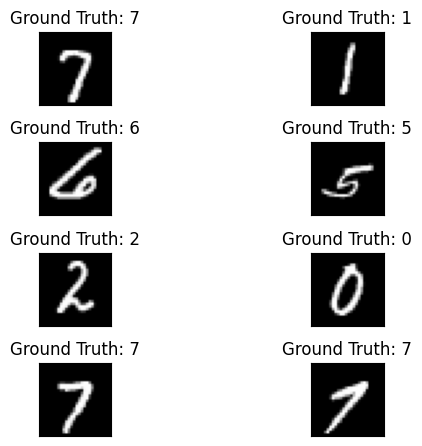

In [ ]:
x, t = next(iter(train_loader))

print(x.shape)

fig = plt.figure()
for i in range(8):
  plt.subplot(4,2,i+1)
  plt.tight_layout()
  plt.imshow(x[i,0,:,:], cmap='gray') #, interpolation='none')
  plt.title("Ground Truth: {}".format(t[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
x.shape

torch.Size([8, 1, 28, 28])

In [ ]:
t.shape

torch.Size([8])

**Exercise 1**:
- Are images sampled by train_loader and val_loader normalized?
  Yes, they are normalized when loaded by passing `tr` as a parameter.
- How much images are in *train_loader* and *val_loader*?
  `train_loader` has 48k images, `val_loader` has 12k
- What will be the role of the validation loader?
  The validation loader is seen by the network only at the end of the training and acts as an evaluation of its performance on previously unseen data.

### **I.B.** A vanilla CNN

Now, we will define a vanilla CNN with two convolution layers.

**Exercise 2:**  Determine *N* in such a way that the network can accept MNIST images as input.
How outputs will be interpreted after the training ?

**Computing N** :
- first layer: conv2d
  - in channel = 1 (grayscale image)
  - out channels = 5
  - kernel size = 5, padding = 2 ⇒ we preserve full image size
  
  Output size: 10x28x28

- second layer: max_pool2d
  - input = output of previous layer
  - kernel_size = 2
  - stride = kernel_size (by default, has to be explicitly provided otherwise)

  Output size: 10x14x14

- third layer: conv2d
  - in channels = 10
  - out channels = 10
  - kernel_size = 5, padding = 2 ⇒ we preserve full image size

  Output size: 10x14x14

- fourth layer: max_pool2d

  Output size: 10x7x7

Input size to fully connected layer: 10x7x7 = 490

**Interpretation of outputs**
The output is a tensor of size 10 representing the probability of the image belonging to each class. The softmax function is:

$$
  σ(x) = (\frac{e^{x_i}}{∑_k e^{x_k}})_i
$$

Taking log softmax helps diminish the number of extremely high values caused by the exponential.

In [ ]:
N = 490

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(10, 10, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(N, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))

        # convert an image to a 1D torch.tensor:
        x = x.view(-1, N)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

### **I.C.** Training of the CNN

To train a CNN, let's define a loss function. Since the log of output probabilities has been computed with *F.log_softmax*, we only need to gather the logits associated with the target classes. This can be done with the torch.gather function (see **P1**), but the standard way in PyTorch is to use *torch.nn.NLLLoss()*.

In [ ]:
model = CNN()

#optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# NLLLoss() will have the same effect as torch.gather (see TP1)
loss_fn =  torch.nn.NLLLoss()

A complete training loop has (at least) two phases: weights are updated only in the first phase dedicated to training. During the validation phase, **generalization performance** on independent images is monitored.

**Exercise 3**:
Complete the following code to print the mean loss and the accuracy on the train and validation sets.

**NOTE** (See executed code before Ex1)

shape(x) = [`batch_size`, channels, height, width]

shape(label) = [`batch_size`]


In [ ]:
import time

num_epochs = 2

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    running_loss_train = 0.0
    running_corrects_train = 0
    running_loss_val = 0.0
    running_corrects_val = 0

    # Phase 1: Training
    model.train()  # Set the model to training mode
    for x, label in train_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, label)
        loss.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Update counters:
        running_loss_train += loss.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores (todo):
    epoch_loss_train = running_loss_train/train_size
    epoch_acc_train = running_corrects_train/train_size

    print(f'Train Loss: {epoch_loss_train:.4f} Acc: {epoch_acc_train:.4f}')

    # Phase 2: Validation
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for x, label in val_loader:
            output = model(x)
            loss = loss_fn(output, label)

            # Get predicted classes:
            _, preds = torch.max(output, 1)

            # Update counters:
            running_loss_val += loss.item() * x.shape[0]
            running_corrects_val += torch.sum(preds == label.data)

    # Calculate validation scores (todo):
    epoch_loss_val = running_loss_val/val_size
    epoch_acc_val = running_corrects_val/val_size

    print(f'Validation Loss: {epoch_loss_val:.4f} Acc: {epoch_acc_val:.4f}')

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

    # Update start time for the next epoch
    start_time = time.time()

Epoch: 0
Train Loss: 0.3097 Acc: 0.9035
Validation Loss: 0.0761 Acc: 0.9762
Time: 51 seconds
Epoch: 1
Train Loss: 0.1450 Acc: 0.9553
Validation Loss: 0.0708 Acc: 0.9802
Time: 51 seconds


In [ ]:
train_losses = []
val_losses = []

train_accs = []
val_accs = []

### BEGIN SOLUTION

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = model(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = model(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')


### END SOLUTION

epoch :0
train Loss: 0.0506 Acc: 0.9848
val Loss: 0.0515 Acc: 0.9851
Time: 50 seconds
epoch :1
train Loss: 0.0389 Acc: 0.9878
val Loss: 0.0506 Acc: 0.9868
Time: 103 seconds
epoch :2
train Loss: 0.0304 Acc: 0.9903
val Loss: 0.0712 Acc: 0.9822
Time: 153 seconds
epoch :3
train Loss: 0.0271 Acc: 0.9915
val Loss: 0.0528 Acc: 0.9863
Time: 202 seconds
epoch :4
train Loss: 0.0227 Acc: 0.9931
val Loss: 0.0636 Acc: 0.9863
Time: 252 seconds
epoch :5
train Loss: 0.0222 Acc: 0.9933
val Loss: 0.0625 Acc: 0.9872
Time: 301 seconds


**Exercise 4**:
At each epoch, store the accuracy and the cost function value in the lists *train_losses*, *val_losses*, *train_accs*, and *val_accs*.
Plot the **learning curves** over six epochs.

In [ ]:
len(train_losses)

6

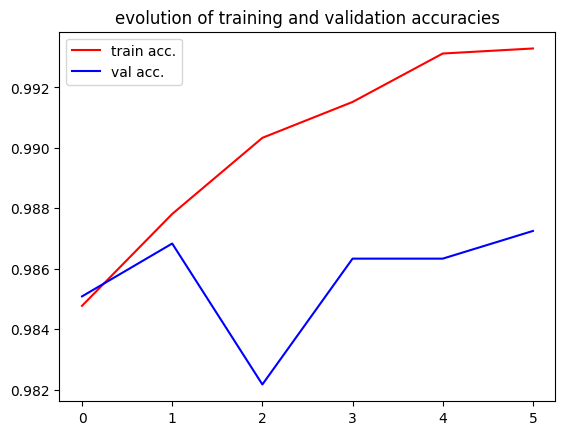

In [ ]:
fig, ax = plt.subplots()
plt.title('evolution of training and validation accuracies')

ax.plot(  train_accs , color = 'r')
ax.plot( val_accs , color = 'b')
ax.legend(['train acc.', 'val acc.'])


In [ ]:
fig2, ax2 = plt.subplots()
plt.title('loss = f(epoch)')
ax2.plot( ... ,  color = 'r')
ax2.plot( ... , color = 'b')
ax2.legend(['train losses', 'val losses'])

**Exercise 5:** Complete the following perceptron (P60) to directly take MNIST images as input.
Compare the standalone perceptron to the CNN in terms of size (number of weights) and performance on a test set.

The model takes MNIST images (flattened) as input ⇒ the input size of the first layer is 1x28x28 = 784

In [ ]:
class P60(nn.Module):

    def __init__(self):
        super(P60, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # flattening x
        x = x.view(-1, 28*28)

        # apply first layer
        x = F.relu(self.fc1(x))

        # apply second layer
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

perceptron = P60()
optimizer = torch.optim.Adam(perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

Computing the number of parameters:
1. CNN
- Layer 1 and 3:
  - weights: `in_channels` * `out_channels` * `kernel_width` * `kernel_height`
  - biases: `out_channels`
- Layer 2 and 4 (max_pooling) don't have weights to update
- FC layers:
  - weights: `input_size` * `output_size`
  - biases: `output_size`


In [ ]:
# Size comparison:
perceptron = P60()

print('CNN:', sum(p.numel() for p in model.parameters()))
print('Perceptron:', sum(p.numel() for p in perceptron.parameters()))

CNN: 27830
Perceptron: 39760


In [ ]:
# Performance comparison (on the validation set):
optimizer = torch.optim.Adam(perceptron.parameters(), lr = 0.001)
loss_fn =  torch.nn.NLLLoss()

# Training the perceptron

train_losses = []
val_losses = []

train_accs = []
val_accs = []

# Initialize time
start_time = time.time()

# Learning Loop:
for epoch in range(6):
    print('epoch :' + str(epoch))

    running_loss_train = 0.
    running_corrects_train = 0.
    running_loss_val = 0.
    running_corrects_val = 0.

    # Training
    for x, label in train_loader:
        optimizer.zero_grad()
        output = perceptron(x)
        l = loss_fn(output, label)
        l.backward()
        optimizer.step()

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_train += l.item() * x.shape[0]
        running_corrects_train += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_train = running_loss_train / train_size
    epoch_acc_train = running_corrects_train.float() / train_size
    train_losses.append(epoch_loss_train)
    train_accs.append(epoch_acc_train)

    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'train', epoch_loss_train, epoch_acc_train))


    # validation
    model.eval()

    for x, label in val_loader:

        with torch.no_grad():
            output = perceptron(x)
            l = loss_fn(output, label)

        # Get predicted classes:
        _, preds = torch.max(output, 1)

        # Counters:
        running_loss_val += l.item() * x.shape[0]
        running_corrects_val += torch.sum(preds == label.data)

    # Calculate training scores and store:
    epoch_loss_val = running_loss_val / val_size
    epoch_acc_val = running_corrects_val.float() / val_size
    val_losses.append(epoch_loss_val)
    val_accs.append(epoch_acc_val)


    print('{} Loss: {:.4f} Acc: {:.4f}'.format(
        'val', epoch_loss_val, epoch_acc_val))

    # Print elapsed time:
    elapsed_time = time.time() - start_time
    print(f'Time: {round(elapsed_time)} seconds')

epoch :0
train Loss: 0.5790 Acc: 0.8153
val Loss: 0.4913 Acc: 0.8419
Time: 29 seconds
epoch :1
train Loss: 0.4424 Acc: 0.8588
val Loss: 0.4551 Acc: 0.8543
Time: 58 seconds
epoch :2
train Loss: 0.4166 Acc: 0.8683
val Loss: 0.4349 Acc: 0.8644
Time: 88 seconds
epoch :3
train Loss: 0.3921 Acc: 0.8753
val Loss: 0.4192 Acc: 0.8758
Time: 117 seconds
epoch :4
train Loss: 0.3859 Acc: 0.8805
val Loss: 0.4025 Acc: 0.8761
Time: 147 seconds
epoch :5
train Loss: 0.3729 Acc: 0.8821
val Loss: 0.3864 Acc: 0.8819
Time: 178 seconds


### **II.A.** Load and viz the Hymenoptera dataset:

Through a second image classification problem, we focus on two other important aspects of deep learning: speeding up the learning with GPU cards and the ability to use pretrained networks.

To illustrate the first aspect, we will use the GPUs available under Google Colab. To do this, before starting this part, go to **Modifier**/**Modifier les param du notebook** and select a GPU.

In [2]:
# Check GPU availability
if torch.cuda.is_available():
  device = torch.device("cuda:0") # 0 is the index of the GPU
  print(torch.cuda.get_device_name(device))
else:
  print('Change the runtime type to GPU')

Tesla T4


Now let's download inputs (RGB images of bees or ants) and targets ("bee" or "ant").

In [3]:
# download the dataset
! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
! unzip -qq hymenoptera_data.zip

--2025-11-19 15:22:48--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.84.215.59, 99.84.215.85, 99.84.215.89, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.84.215.59|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   293MB/s    in 0.2s    

2025-11-19 15:22:48 (293 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
dir_data = 'hymenoptera_data'
print(os.listdir(dir_data))

['val', 'train']


The dataset is in a standard format, and we can manipulate it with a ready-to-use dataset object of the datasets.ImageFolder class:

In [5]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomVerticalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dir_data, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

print('Dataset sizs:' )
print(dataset_sizes)

Dataset sizs:
{'train': 244, 'val': 153}


In [7]:
image_datasets1 = {x: datasets.ImageFolder(os.path.join(dir_data, x))
                  for x in ['train', 'val']}
dataset_sizes1 = {x: len(image_datasets1[x]) for x in ['train', 'val']}
print(dataset_sizes1)

{'train': 244, 'val': 153}


Since the provided dataset is very small, we need to maximize its utility. We will produce new images through additional transformations that preserve the nature of the object (data augmentation). \
In the code, transforms.*RandomResizedCrop()*, *transforms.RandomHorizontalFlip()* and *transforms.RandomVerticalFlip()* apply horizontal or vertical axis symmetry with a probability of 1/2. Note that these transformations might not be suitable for other datasets like MNIST since the mirror image of a digit is generally not another digit. \
Some images are presented below.

In [12]:
def imshow(inp, ax=None, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    if ax is None:
      plt.imshow(inp)
      plt.title(title)
    else:
      ax.imshow(inp)
      ax.set_title(title)

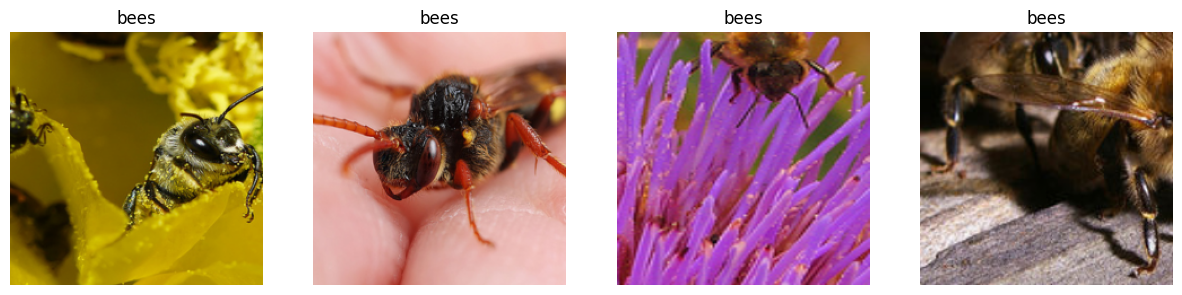

In [13]:
def plot_batch(images, labels, class_names):
    num_images = len(images)
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        axs[i].axis('off')
        imshow(images[i],axs[i],class_names[labels[i]])
    plt.show()

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
class_names = image_datasets['train'].classes
# Assuming `inputs` is a batch of images and `classes` are the corresponding class labels
plot_batch(inputs, classes, class_names)

### **II.B.** Adaptation of a ResNet18 architecture:

In this part, the lightest of the ResNet architectures is adapted to our binary classification problem and trained over one epoch.

**Exercise 6:**

- Load an untrained ResNet18. How many total weights does it contain? Check [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html).

- How many neurons does the last layer of the network have?

Last layer is a fully connected layer ⇒ nb_neurons = 1000

- Is there a softmax operation at the end of *ResNet.forward()*?

No, there isn't, the output is given as raw numbers called `logits`.

- Modify the last layer of the classifier so that it has as many neurons as there are classes in hymenoptera_data.

In [14]:
model = models.resnet18(pretrained=False)
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
sum(p.numel() for p in model.parameters())

11689512

In [15]:
# Modification of the last layer of the classifier
def get_model(pretrained):
  model = models.resnet18(pretrained=pretrained)

  model.fc = nn.Linear(512, 2)

  return model

model = get_model(False)

Now, let's define the negative log-likelihood as the cost function. To compute the log-likelihood, we could add a LogSoftmax layer to the ResNet. Another common way to do that is to use a loss function that includes *LogSoftmax*. In this regard, in PyTorch,  *nn.CrossEntropyLoss* combines both *LogSoftmax* and *NLLLoss*.

In [16]:
loss_fn = nn.CrossEntropyLoss()

Finally, let's define a function that incorporates the training loop:

In [19]:
import time

def train_model(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                # Weights are not updated during the validation phase

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

**Exercise 7:** With the *train_model* function, train the ResNet over one epoch with mini-batches of 64 images.

In [20]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

model = get_model(pretrained=False)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_model(dataloaders, model, loss_fn, optimizer)

Epoch 0/0
----------
train Loss: 0.7338 Acc: 50.41%
val Loss: 0.7050 Acc: 49.67%
Training complete in 0m 50s


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **II.C.** Using a Graphics Card:

With more than 10 million parameters, training a ResNet18 on a CPU is much slower than the networks in Part I. \
Let's repeat the same training using the GPU.

In [21]:
print(f'Runtime device :{device}')

# Load the model to the GPU:
model = model.to(device)

Runtime device :cuda:0


To load a torch.tensor on GPU, the syntax is the same:

In [22]:
x = torch.rand(2,1,4,4)
print("On CPU :\n",x)
x = x.to(device)
# Note: You can also use .cuda() without specifying the device name
# but this method is not recommended especially in a multi-gpu environment
print("On GPU :\n",x)

# bring back the x tensor to the CPU RAM:
x = x.to('cpu') # or x.cpu()
print('Back to CPU:\n',x)

On CPU :
 tensor([[[[0.5055, 0.1564, 0.2101, 0.4527],
          [0.0278, 0.5282, 0.1763, 0.0196],
          [0.6821, 0.0846, 0.6663, 0.6126],
          [0.3937, 0.1390, 0.9135, 0.1197]]],


        [[[0.0113, 0.6988, 0.1162, 0.0948],
          [0.9979, 0.2135, 0.3250, 0.9156],
          [0.1060, 0.0777, 0.6273, 0.6701],
          [0.7482, 0.6523, 0.7762, 0.6440]]]])
On GPU :
 tensor([[[[0.5055, 0.1564, 0.2101, 0.4527],
          [0.0278, 0.5282, 0.1763, 0.0196],
          [0.6821, 0.0846, 0.6663, 0.6126],
          [0.3937, 0.1390, 0.9135, 0.1197]]],


        [[[0.0113, 0.6988, 0.1162, 0.0948],
          [0.9979, 0.2135, 0.3250, 0.9156],
          [0.1060, 0.0777, 0.6273, 0.6701],
          [0.7482, 0.6523, 0.7762, 0.6440]]]], device='cuda:0')
Back to CPU:
 tensor([[[[0.5055, 0.1564, 0.2101, 0.4527],
          [0.0278, 0.5282, 0.1763, 0.0196],
          [0.6821, 0.0846, 0.6663, 0.6126],
          [0.3937, 0.1390, 0.9135, 0.1197]]],


        [[[0.0113, 0.6988, 0.1162, 0.0948],
       

**Exercise 8:**
- Complete the fonction *train_model_gpu* to train the model on GPU.
- Compare the CPU and GPU training times.
- What are the validation scores after 20 epochs on GPUs ?

In [23]:
def train_model_gpu(dataloaders, model, loss_fn, optimizer, num_epochs=1):
    since = time.time()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                # Weights are not updated during the validation phase

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {100*epoch_acc:.2f}%')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return model

In [27]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

train_model(dataloaders, model, loss_fn, optimizer)

Epoch 0/0
----------
train Loss: 0.6896 Acc: 52.87%
val Loss: 0.6838 Acc: 57.52%
Training complete in 0m 4s


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### **II.D.** Impact of pretraining on performance:

Training is faster on a GPU, but it only leads to a very poor score, barely better than random chance. To improve performance, a simple idea is to use a network trained on a similar (or more general) task as a starting point for learning. Here, it works particularly well with networks trained on ImageNet, whose convolutional filters are already very rich.

**Note:**
This method is refered to as **fine-tuning** a **pretrained model**.

**Exercise 9:** Compare two ResNet18 trainings, one randomly initialized and the other pre-trained, using learning curves, over 25 epochs.

In [29]:
max_epochs = 25
# Learning "from scratch" (random weights) :
# get the model
resnet_untrained = get_model(False)
# get the loss, optimize, the scheduler and starting the training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                                   gamma=0.1)
# Put the model on GPU
resnet_untrained = resnet_untrained.to(device)
# get the loss, optimize, the scheduler and starting the training
fine_tuned_random_model = train_model_gpu(dataloaders, resnet_untrained, loss_fn, optimizer, num_epochs = 25)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 0.8284 Acc: 49.59%
val Loss: 0.6920 Acc: 54.25%
Epoch 1/24
----------
train Loss: 0.8229 Acc: 49.59%
val Loss: 0.7175 Acc: 54.25%
Epoch 2/24
----------
train Loss: 0.8239 Acc: 49.59%
val Loss: 0.7382 Acc: 54.25%
Epoch 3/24
----------
train Loss: 0.8215 Acc: 50.00%
val Loss: 0.7521 Acc: 54.25%
Epoch 4/24
----------
train Loss: 0.8244 Acc: 49.59%
val Loss: 0.7600 Acc: 54.25%
Epoch 5/24
----------
train Loss: 0.8231 Acc: 49.59%
val Loss: 0.7640 Acc: 54.25%
Epoch 6/24
----------
train Loss: 0.8307 Acc: 50.00%
val Loss: 0.7656 Acc: 54.25%
Epoch 7/24
----------
train Loss: 0.8247 Acc: 50.00%
val Loss: 0.7640 Acc: 54.25%
Epoch 8/24
----------
train Loss: 0.8250 Acc: 49.59%
val Loss: 0.7619 Acc: 54.25%
Epoch 9/24
----------
train Loss: 0.8213 Acc: 50.00%
val Loss: 0.7618 Acc: 54.25%
Epoch 10/24
----------
train Loss: 0.8214 Acc: 49.59%
val Loss: 0.7633 Acc: 54.25%
Epoch 11/24
----------
train Loss: 0.8230 Acc: 49.59%
val Loss: 0.7632 Acc: 54.25%
Epoch 12/24
--

In [31]:
# fine tuning a pretrained model:
resnet_pretrained = get_model(True)
# get the loss, optimize, the scheduler and starting the training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10,
                                                   gamma=0.1)
# Put the model on GPU
resnet_pretrained = resnet_pretrained.to(device)
# get the loss, optimize, the scheduler and starting the training
fine_tuned_pretrained_model = train_model_gpu(dataloaders, resnet_pretrained, loss_fn, optimizer, num_epochs = 25)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


Epoch 0/24
----------
train Loss: 0.8026 Acc: 46.31%
val Loss: 0.7956 Acc: 50.33%
Epoch 1/24
----------
train Loss: 0.7897 Acc: 47.95%
val Loss: 0.7969 Acc: 51.63%
Epoch 2/24
----------
train Loss: 0.7907 Acc: 47.13%
val Loss: 0.7931 Acc: 49.67%
Epoch 3/24
----------
train Loss: 0.7989 Acc: 47.13%
val Loss: 0.7898 Acc: 50.98%
Epoch 4/24
----------
train Loss: 0.8173 Acc: 44.67%
val Loss: 0.7895 Acc: 51.63%
Epoch 5/24
----------
train Loss: 0.7770 Acc: 49.59%
val Loss: 0.7912 Acc: 51.63%
Epoch 6/24
----------
train Loss: 0.7880 Acc: 46.31%
val Loss: 0.7915 Acc: 51.63%
Epoch 7/24
----------
train Loss: 0.7878 Acc: 47.54%
val Loss: 0.7906 Acc: 51.63%
Epoch 8/24
----------
train Loss: 0.8062 Acc: 46.72%
val Loss: 0.7906 Acc: 52.29%
Epoch 9/24
----------
train Loss: 0.7719 Acc: 47.54%
val Loss: 0.7874 Acc: 52.29%
Epoch 10/24
----------
train Loss: 0.7785 Acc: 46.72%
val Loss: 0.7872 Acc: 52.29%
Epoch 11/24
----------
train Loss: 0.7913 Acc: 48.36%
val Loss: 0.7884 Acc: 52.94%
Epoch 12/24
--

The fine-tuning approach has many variations that fit into the broader framework of **transfer learning**. Partial fine-tuning, as illustrated in the following exercise, is one of these variations.

**Exercise 10:** Instead of retraining all the weights, you can simply use the weights of the classifier. This is referred to as *freezing* the other weights during retraining. \
Implement this approach and compare it with the previous ones.

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 2)

# freeze all the layers except the classifier (the last dense layers at end)
# using this snippet :
for module in resnet.modules() :
  if isinstance(module, nn.Conv2d) or isinstance(module, nn.BatchNorm2d):
    for param in module.parameters():
      param.requires_grad = False


freezed_resnet = resnet.to(device)

optimizer = torch.optim.SGD(freezed_resnet.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

freezed_resnet = freezed_resnet.to(device)
freezed_resnet, _, accs_freezing = train_model_gpu_(dataloaders,
                                                freezed_resnet,
                                                loss_function,
                                                optimizer,
                                                num_epochs=max_epochs)


In the end, for this small dataset, retraining the last layer performs just as well as global training. To conclude, let's make some predictions with the model on the validation dataset:

In [ ]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(25,num_images//5*5))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//5, 5, images_so_far)
                ax.axis('off')
                imshow(inputs.cpu().data[j],ax,'Predicted: {}'.format(class_names[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)